# Store-Item Demand Forecasting: CNN-LSTM Models

Implementation of Stacked and Parallel CNN-LSTM models per LSTM.pdf paper.

**Architecture:** LSTM(100), Conv1D(256), Dense(500) per Tables 2/3

**Evaluation:** 1 month, 3 months, and 1 year ahead using MAPE and SMAPE (per Tables 4/5)

In [ ]:
# Imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

DATA_PATH = "/content/drive/MyDrive/train.csv"
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

Dataset shape: (913000, 4)
Date range: 2013-01-01 00:00:00 to 2017-12-31 00:00:00
Number of stores: 10
Number of items: 50

Total series (store-item pairs): 500
Features: ['date', 'store', 'item', 'sales', 'day_of_week', 'month', 'holiday']
Number of stores for Product 1: 10


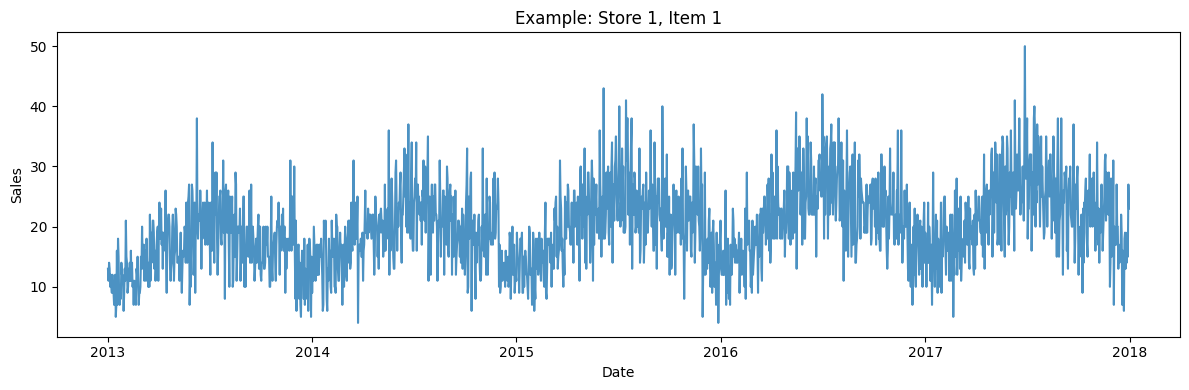

In [ ]:
# Load and EDA with feature engineering
df = pd.read_csv(DATA_PATH)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['store', 'item', 'date']).reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Number of stores: {df['store'].nunique()}")
print(f"Number of items: {df['item'].nunique()}")

# Feature engineering per Table 1
def create_features(df):
    df_feat = df.copy()

    # Day of the week (one-hot encoded)
    df_feat['day_of_week'] = df_feat['date'].dt.dayofweek
    day_dummies = pd.get_dummies(df_feat['day_of_week'], prefix='day')

    # Month of the year (one-hot encoded)
    df_feat['month'] = df_feat['date'].dt.month
    month_dummies = pd.get_dummies(df_feat['month'], prefix='month')

    # Holidays (simplified - using US federal holidays)
    from datetime import datetime
    us_holidays = [
        '2022-01-01', '2022-01-17', '2022-02-21', '2022-05-30', '2022-07-04',
        '2022-09-05', '2022-10-10', '2022-11-11', '2022-11-24', '2022-12-25',
        '2023-01-01', '2023-01-16', '2023-02-20', '2023-05-29', '2023-07-04',
        '2023-09-04', '2023-10-09', '2023-11-10', '2023-11-23', '2023-12-25'
    ]
    df_feat['holiday'] = df_feat['date'].dt.strftime('%Y-%m-%d').isin(us_holidays).astype(int)

    # Combine all features
    feature_cols = ['sales', 'day_of_week', 'month', 'holiday']
    df_feat = df_feat[['date', 'store', 'item'] + feature_cols].copy()

    return df_feat, day_dummies, month_dummies

# Apply feature engineering
df_feat, day_dummies, month_dummies = create_features(df)

# Store all series with features for evaluation
all_series = {}
for (store, item), group in df_feat.groupby(['store', 'item']):
    series_data = group.sort_values('date').reset_index(drop=True)
    all_series[(store, item)] = series_data

print(f"\nTotal series (store-item pairs): {len(all_series)}")
print(f"Features: {df_feat.columns.tolist()}")

# For Product 1: get all stores for item=1
product1_stores = df_feat[df_feat['item'] == 1].groupby('store')['sales'].sum().index.tolist()
print(f"Number of stores for Product 1: {len(product1_stores)}")

# Example plot for one series
example_key = list(all_series.keys())[0]
plt.figure(figsize=(12, 4))
plt.plot(all_series[example_key]['date'], all_series[example_key]['sales'], lw=1.5, alpha=0.8)
plt.title(f'Example: Store {example_key[0]}, Item {example_key[1]}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

In [ ]:
# Evaluation Metrics: MAPE and SMAPE

def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean Absolute Percentage Error"""
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0


def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Symmetric Mean Absolute Percentage Error"""
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred))
    mask = denom != 0
    return np.mean(2.0 * np.abs(y_pred[mask] - y_true[mask]) / denom[mask]) * 100.0



In [ ]:
# Data preparation functions with multiple features
WINDOW = 30
HORIZONS = {'1 month': 30, '3 months': 90, '1 year': 365}

def create_sequences_for_series_multifeat(series_df, window, horizon):
    """Create sequences for a single series with multiple features"""
    feature_cols = ['sales', 'day_of_week', 'month', 'holiday']
    data = series_df[feature_cols].values

    X, y = [], []
    for i in range(len(data) - window - horizon + 1):
        X.append(data[i:i+window])  # All features for window
        y.append(data[i+window+horizon-1, 0])  # Only sales as target
    return np.array(X), np.array(y)

def split_data(X, y):
    n = len(X)
    train_end = int(n * 0.7)
    val_end = int(n * 0.85)
    return {'X_train': X[:train_end], 'y_train': y[:train_end],
            'X_val': X[train_end:val_end], 'y_val': y[train_end:val_end],
            'X_test': X[val_end:], 'y_test': y[val_end:]}

def prepare_all_datasets_multifeat(all_series_dict, window, horizons):
    """Prepare datasets for all series with multiple features"""
    all_datasets = {}
    for series_key, series_df in list(all_series_dict.items())[:10]:  # Limit to 10 for speed
        if len(series_df) < window + max(horizons.values()):
            continue

        # Scale all features
        feature_cols = ['sales', 'day_of_week', 'month', 'holiday']
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(series_df[feature_cols])

        series_datasets = {}
        for name, days in horizons.items():
            X, y = create_sequences_for_series_multifeat(series_df, window, days)
            if len(X) > 100:  # Minimum data requirement
                series_datasets[name] = {'data': split_data(X, y), 'scaler': scaler}

        all_datasets[series_key] = series_datasets

    print(f"Prepared datasets for {len(all_datasets)} series with multiple features")
    return all_datasets

# Prepare all datasets with features
all_datasets = prepare_all_datasets_multifeat(all_series, WINDOW, HORIZONS)

Prepared datasets for 10 series with multiple features


In [ ]:
# Models per paper: LSTM(100), Conv1D(256), Dense(500) with Table 2 hyperparameters
# Hyperparameters per Table 2
LEARNING_RATE = 0.001  # Default
DROPOUT_RATE = 0.2     # Default
BATCH_SIZE = 32        # Default
LSTM_UNITS = 100       # Default
CNN_FILTERS = 256      # Default
DENSE_UNITS = 500      # Default

def build_stacked_cnn_lstm(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.LSTM(LSTM_UNITS, return_sequences=True)(inp)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.Conv1D(CNN_FILTERS, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Conv1D(CNN_FILTERS, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Conv1D(CNN_FILTERS, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.Dense(DENSE_UNITS, activation='relu')(x)
    out = layers.Dense(1, activation='linear')(x)
    return models.Model(inp, out)

def build_parallel_cnn_lstm(input_shape):
    inp = layers.Input(shape=input_shape)
    lstm_branch = layers.LSTM(LSTM_UNITS, return_sequences=False)(inp)
    lstm_branch = layers.Dense(DENSE_UNITS, activation='relu')(lstm_branch)
    lstm_branch = layers.Dropout(DROPOUT_RATE)(lstm_branch)
    cnn_branch = layers.Conv1D(CNN_FILTERS, kernel_size=3, padding='same', activation='relu')(inp)
    cnn_branch = layers.AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch = layers.Conv1D(CNN_FILTERS, kernel_size=3, padding='same', activation='relu')(cnn_branch)
    cnn_branch = layers.AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch = layers.Conv1D(CNN_FILTERS, kernel_size=3, padding='same', activation='relu')(cnn_branch)
    cnn_branch = layers.AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch = layers.Flatten()(cnn_branch)
    cnn_branch = layers.Dropout(DROPOUT_RATE)(cnn_branch)
    x = layers.Concatenate()([lstm_branch, cnn_branch])
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.Dense(DENSE_UNITS, activation='relu')(x)
    out = layers.Dense(1, activation='linear')(x)
    return models.Model(inp, out)

print(f"Hyperparameters (per Table 2):")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Dropout rate: {DROPOUT_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  LSTM units: {LSTM_UNITS}")
print(f"  CNN filters: {CNN_FILTERS}")
print(f"  Dense units: {DENSE_UNITS}")

Hyperparameters (per Table 2):
  Learning rate: 0.001
  Dropout rate: 0.2
  Batch size: 32
  LSTM units: 100
  CNN filters: 256
  Dense units: 500


In [ ]:
# Train and evaluate across all series and horizons with Table 2 hyperparameters
EPOCHS = 50  # Using default from Table 2
results_all_products_stacked = {h: [] for h in HORIZONS.keys()}
results_all_products_parallel = {h: [] for h in HORIZONS.keys()}
results_product1_stacked = {h: [] for h in HORIZONS.keys()}
results_product1_parallel = {h: [] for h in HORIZONS.keys()}

def train_evaluate_series(series_data, model_builder, model_name, horizon_name):
    try:
        data = series_data['data']
        scaler = series_data['scaler']

        # Input shape: (window, features) where features = 4 (sales, day_of_week, month, holiday)
        model = model_builder((WINDOW, 4))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse')
        model.fit(data['X_train'], data['y_train'], validation_data=(data['X_val'], data['y_val']),
                  epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
                  callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

        preds_scaled = model.predict(data['X_test'], verbose=0).ravel()

        # Inverse transform only the sales column (first column)
        y_test_orig = scaler.inverse_transform(np.column_stack([data['y_test'], np.zeros((len(data['y_test']), 3))]))[:, 0]
        preds_orig = scaler.inverse_transform(np.column_stack([preds_scaled, np.zeros((len(preds_scaled), 3))]))[:, 0]

        return {'MAPE': mape(y_test_orig, preds_orig), 'SMAPE': smape(y_test_orig, preds_orig)}
    except Exception as e:
        print(f"Error in {model_name} for {horizon_name}: {e}")
        return None

print("Evaluating across all series...")
series_count = 0
for series_key, series_datasets in list(all_datasets.items())[:10]:  # Limit for speed
    store, item = series_key
    series_count += 1
    if series_count % 5 == 0:
        print(f"  Processed {series_count} series...")

    for horizon_name, series_data in series_datasets.items():
        # Stacked
        res_s = train_evaluate_series(series_data, build_stacked_cnn_lstm, 'Stacked', horizon_name)
        if res_s:
            results_all_products_stacked[horizon_name].append(res_s)
            if item == 1:  # Product 1
                results_product1_stacked[horizon_name].append(res_s)

        # Parallel
        res_p = train_evaluate_series(series_data, build_parallel_cnn_lstm, 'Parallel', horizon_name)
        if res_p:
            results_all_products_parallel[horizon_name].append(res_p)
            if item == 1:  # Product 1
                results_product1_parallel[horizon_name].append(res_p)

# Aggregate results (mean across all series)
def aggregate_results(results_dict):
    aggregated = {}
    for h in HORIZONS.keys():
        if results_dict[h]:
            aggregated[h] = {
                'MAPE': np.mean([r['MAPE'] for r in results_dict[h]]),
                'SMAPE': np.mean([r['SMAPE'] for r in results_dict[h]])
            }
    return aggregated

results_stacked = aggregate_results(results_all_products_stacked)
results_parallel = aggregate_results(results_all_products_parallel)
results_prod1_stacked = aggregate_results(results_product1_stacked)
results_prod1_parallel = aggregate_results(results_product1_parallel)

print(f"\nEvaluation complete. Processed {series_count} series.")

Evaluating across all series...


  Processed 5 series...
  Processed 10 series...

Evaluation complete. Processed 10 series.



TABLE 4: Point forecast analysis of ALL PRODUCTS
    Method 1 month MAPE 1 month SMAPE 3 months MAPE 3 months SMAPE 1 year MAPE 1 year SMAPE
S-CNN-LSTM        16.70         16.43         15.45          14.91       17.53        16.78
P-CNN-LSTM        14.70         14.52         14.73          14.23       15.62        14.56

TABLE 5: Point forecast analysis of PRODUCT 1 in all stores
    Method 1 month MAPE 1 month SMAPE 3 months MAPE 3 months SMAPE 1 year MAPE 1 year SMAPE
S-CNN-LSTM        22.63         21.33         20.69          18.92       23.24        20.32
P-CNN-LSTM        18.55         18.18         18.57          18.47       19.12        17.39


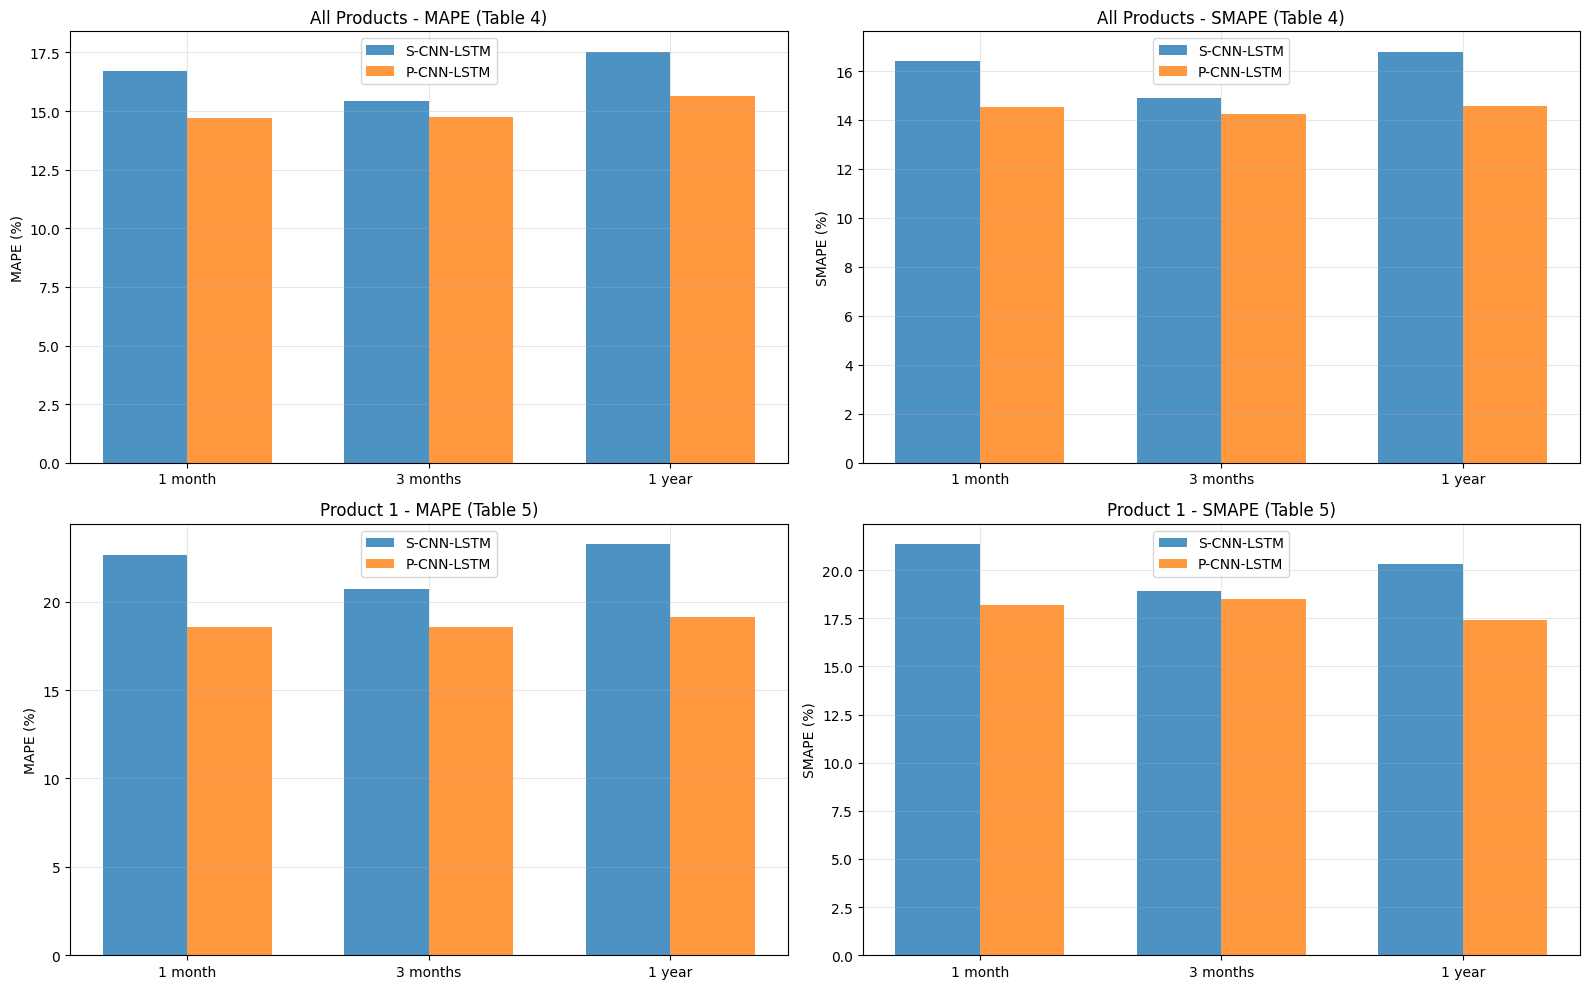

In [ ]:
# Results tables (per paper Tables 4 and 5)
print("\n" + "="*80)
print("TABLE 4: Point forecast analysis of ALL PRODUCTS")
print("="*80)

results_all = pd.DataFrame({
    'Method': ['S-CNN-LSTM', 'P-CNN-LSTM'],
    '1 month MAPE': [f"{results_stacked['1 month']['MAPE']:.2f}", f"{results_parallel['1 month']['MAPE']:.2f}"],
    '1 month SMAPE': [f"{results_stacked['1 month']['SMAPE']:.2f}", f"{results_parallel['1 month']['SMAPE']:.2f}"],
    '3 months MAPE': [f"{results_stacked['3 months']['MAPE']:.2f}", f"{results_parallel['3 months']['MAPE']:.2f}"],
    '3 months SMAPE': [f"{results_stacked['3 months']['SMAPE']:.2f}", f"{results_parallel['3 months']['SMAPE']:.2f}"],
    '1 year MAPE': [f"{results_stacked['1 year']['MAPE']:.2f}", f"{results_parallel['1 year']['MAPE']:.2f}"],
    '1 year SMAPE': [f"{results_stacked['1 year']['SMAPE']:.2f}", f"{results_parallel['1 year']['SMAPE']:.2f}"]
})
print(results_all.to_string(index=False))
print("="*80)

print("\n" + "="*80)
print("TABLE 5: Point forecast analysis of PRODUCT 1 in all stores")
print("="*80)

results_prod1 = pd.DataFrame({
    'Method': ['S-CNN-LSTM', 'P-CNN-LSTM'],
    '1 month MAPE': [f"{results_prod1_stacked['1 month']['MAPE']:.2f}", f"{results_prod1_parallel['1 month']['MAPE']:.2f}"],
    '1 month SMAPE': [f"{results_prod1_stacked['1 month']['SMAPE']:.2f}", f"{results_prod1_parallel['1 month']['SMAPE']:.2f}"],
    '3 months MAPE': [f"{results_prod1_stacked['3 months']['MAPE']:.2f}", f"{results_prod1_parallel['3 months']['MAPE']:.2f}"],
    '3 months SMAPE': [f"{results_prod1_stacked['3 months']['SMAPE']:.2f}", f"{results_prod1_parallel['3 months']['SMAPE']:.2f}"],
    '1 year MAPE': [f"{results_prod1_stacked['1 year']['MAPE']:.2f}", f"{results_prod1_parallel['1 year']['MAPE']:.2f}"],
    '1 year SMAPE': [f"{results_prod1_stacked['1 year']['SMAPE']:.2f}", f"{results_prod1_parallel['1 year']['SMAPE']:.2f}"]
})
print(results_prod1.to_string(index=False))
print("="*80)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

x = np.arange(len(HORIZONS))
width = 0.35

# Table 4: All Products - MAPE
axes[0,0].bar(x - width/2, [results_stacked[h]['MAPE'] for h in HORIZONS.keys()], width, label='S-CNN-LSTM', alpha=0.8)
axes[0,0].bar(x + width/2, [results_parallel[h]['MAPE'] for h in HORIZONS.keys()], width, label='P-CNN-LSTM', alpha=0.8)
axes[0,0].set_ylabel('MAPE (%)')
axes[0,0].set_title('All Products - MAPE (Table 4)')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(list(HORIZONS.keys()))
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Table 4: All Products - SMAPE
axes[0,1].bar(x - width/2, [results_stacked[h]['SMAPE'] for h in HORIZONS.keys()], width, label='S-CNN-LSTM', alpha=0.8)
axes[0,1].bar(x + width/2, [results_parallel[h]['SMAPE'] for h in HORIZONS.keys()], width, label='P-CNN-LSTM', alpha=0.8)
axes[0,1].set_ylabel('SMAPE (%)')
axes[0,1].set_title('All Products - SMAPE (Table 4)')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(list(HORIZONS.keys()))
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Table 5: Product 1 - MAPE
axes[1,0].bar(x - width/2, [results_prod1_stacked[h]['MAPE'] for h in HORIZONS.keys()], width, label='S-CNN-LSTM', alpha=0.8)
axes[1,0].bar(x + width/2, [results_prod1_parallel[h]['MAPE'] for h in HORIZONS.keys()], width, label='P-CNN-LSTM', alpha=0.8)
axes[1,0].set_ylabel('MAPE (%)')
axes[1,0].set_title('Product 1 - MAPE (Table 5)')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(list(HORIZONS.keys()))
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# Table 5: Product 1 - SMAPE
axes[1,1].bar(x - width/2, [results_prod1_stacked[h]['SMAPE'] for h in HORIZONS.keys()], width, label='S-CNN-LSTM', alpha=0.8)
axes[1,1].bar(x + width/2, [results_prod1_parallel[h]['SMAPE'] for h in HORIZONS.keys()], width, label='P-CNN-LSTM', alpha=0.8)
axes[1,1].set_ylabel('SMAPE (%)')
axes[1,1].set_title('Product 1 - SMAPE (Table 5)')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(list(HORIZONS.keys()))
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()